# Carsen Essing Machine Learning Assignment 2

# Upload Q3 LA Data from GitHub

In [271]:
import requests
import io
import pandas as pd

# Raw URL to your zip file on GitHub
url = "https://raw.githubusercontent.com/CarsenEssing/Essing_ML_Assignment2/main/LAQ3_reduced.zip"

# Download the file as bytes
response = requests.get(url)
response.raise_for_status()  # Raises an error if the download fails

# Open the downloaded content as a ZipFile
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List the files in the zip archive (for verification)
    print("Files in the zip:", z.namelist())
    # Assuming the CSV file inside is named 'LAQ3_reduced.csv'
    df = pd.read_csv(z.open("LAQ3_reduced.csv"))

print("Data loaded successfully:")
print(df.head())


Files in the zip: ['LAQ3_reduced.csv']
Data loaded successfully:
                    id         property_type        room_type  accommodates  \
0   670339032744709144          Entire condo  Entire home/apt             6   
1             37014494    Entire rental unit  Entire home/apt             2   
2  1024835174766068422           Entire home  Entire home/apt             6   
3   850744632375448560  Private room in home     Private room             2   
4   953950676345326970    Entire rental unit  Entire home/apt             2   

   bedrooms  bathrooms  beds    price  minimum_nights  maximum_nights  \
0       3.0        3.0   3.0  $399.00              30             365   
1       2.0        NaN   NaN      NaN              30             270   
2       3.0        3.0   3.0  $434.00              30             365   
3       1.0        1.0   1.0   $49.00               1             365   
4       0.0        1.0   1.0  $231.00               5              29   

                     

# Data Wrangling

## Clean up price and amenities columns
* I cleaned up the price and amenities columns to convert the raw, unstructured data into a usable format. This involved transforming the price from a string with currency symbols into a numerical value and processing the amenities into a consistent structure, ensuring accurate and efficient analysis and modeling.


In [273]:
# Remove the dollar sign and any commas, then convert the string to a float.
df['price_clean'] = df['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

# Print the original and cleaned price columns to verify changes.
print("Price before and after cleaning:")
print(df[['price', 'price_clean']].head())

# Process the 'amenities' column:
# Remove the enclosing square brackets and quotes, then split the string into a list.
df['amenities_list'] = df['amenities'].apply(lambda x: x.strip('[]"').split('", "'))

# Print a sample of the processed amenities column.
print("\nSample of processed amenities column:")
print(df[['amenities', 'amenities_list']].head())


Price before and after cleaning:
     price  price_clean
0  $399.00        399.0
1      NaN          NaN
2  $434.00        434.0
3   $49.00         49.0
4  $231.00        231.0

Sample of processed amenities column:
                                           amenities  \
0  ["Dedicated workspace", "Air conditioning", "K...   
1  ["Air conditioning", "Pets allowed", "Hot wate...   
2  ["Air conditioning", "Kitchen", "Carbon monoxi...   
3  ["Dedicated workspace", "Air conditioning", "K...   
4  ["Clothing storage: closet", "Shared beach acc...   

                                      amenities_list  
0  [Dedicated workspace, Air conditioning, Kitche...  
1  [Air conditioning, Pets allowed, Hot water, Ki...  
2  [Air conditioning, Kitchen, Carbon monoxide al...  
3  [Dedicated workspace, Air conditioning, Kitche...  
4  [Clothing storage: closet, Shared beach access...  


## Create bianary code for popular amenities
* I created binary variables for popular amenities to convert categorical data into a numerical format that machine learning models can easily use. This step ensures that the presence or absence of specific features is captured effectively, improving the model's ability to learn and predict accurately.


In [275]:
# Define a list of popular amenities to extract as binary features.
# You may adjust this list based on what appears in your dataset.
popular_amenities = [
    "Air conditioning", 
    "Wifi", 
    "Kitchen", 
    "Heating", 
    "Washer", 
    "Dryer", 
    "TV", 
    "Cable TV", 
    "Free parking on premises", 
    "Pool", 
    "Hot water"
]

# For each amenity, create a new binary column.
for amenity in popular_amenities:
    # Create a column name by replacing spaces with underscores and converting to lowercase.
    col_name = f"amenity_{amenity.replace(' ', '_').lower()}"
    df[col_name] = df["amenities_list"].apply(lambda x: 1 if amenity in x else 0)

# Display the first few rows of the new binary amenity columns.
binary_columns = [f"amenity_{amenity.replace(' ', '_').lower()}" for amenity in popular_amenities]
print("Binary amenity columns:")
print(df[binary_columns].head())


Binary amenity columns:
   amenity_air_conditioning  amenity_wifi  amenity_kitchen  amenity_heating  \
0                         1             1                1                0   
1                         1             1                1                1   
2                         1             1                1                0   
3                         1             1                1                0   
4                         1             1                1                1   

   amenity_washer  amenity_dryer  amenity_tv  amenity_cable_tv  \
0               1              0           1                 0   
1               1              1           1                 0   
2               1              0           1                 0   
3               1              0           0                 0   
4               0              0           0                 0   

   amenity_free_parking_on_premises  amenity_pool  amenity_hot_water  
0                                

In [283]:
# Calculate missing percentages for each column
missing_percentages = (df.isnull().sum() / df.shape[0]) * 100
print("Missing percentages per column:")
print(missing_percentages.sort_values(ascending=False))


Missing percentages per column:
review_scores_rating                26.675159
reviews_per_month                   26.675159
beds                                18.303209
bathrooms                           18.094569
price_clean                         18.090176
price                               18.090176
bedrooms                             6.674280
amenity_washer                       0.000000
amenity_wifi                         0.000000
amenity_kitchen                      0.000000
amenity_heating                      0.000000
id                                   0.000000
amenity_dryer                        0.000000
amenity_air_conditioning             0.000000
amenity_cable_tv                     0.000000
amenity_free_parking_on_premises     0.000000
amenity_pool                         0.000000
amenity_tv                           0.000000
longitude                            0.000000
amenities_list                       0.000000
neighbourhood_cleansed               0.000000
pr

## Handle missing values
* I removed rows with missing cleaned price values because price is essential for our predictions and we need complete data. I filtered the dataset to include only "Entire home/apt" listings and dropped rows missing key room details (bedrooms, bathrooms, beds) to ensure data quality. Finally, I imputed missing review metrics with 0, assuming listings with no reviews have no ratings or review frequency, which helps maintain a consistent dataset for modeling.

In [285]:
# Drop rows where the 'price_clean' value is missing
df = df.dropna(subset=['price_clean'])

# Filter the DataFrame to keep only rows with room_type "Entire home/apt"
df = df[df['room_type'] == "Entire home/apt"]

# Drop rows where 'bedrooms', 'bathrooms', or 'beds' are missing
df = df.dropna(subset=['bedrooms', 'bathrooms', 'beds'])

# Impute missing values for 'reviews_per_month' and 'review_scores_rating' with 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)

# Verify that missing values are handled
print("Missing values per column after filtering:")
print(df.isnull().sum())


Missing values per column after filtering:
id                                  0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                            0
bathrooms                           0
beds                                0
price                               0
minimum_nights                      0
maximum_nights                      0
amenities                           0
number_of_reviews                   0
reviews_per_month                   0
review_scores_rating                0
latitude                            0
longitude                           0
neighbourhood_cleansed              0
price_clean                         0
amenities_list                      0
amenity_air_conditioning            0
amenity_wifi                        0
amenity_kitchen                     0
amenity_heating                     0
amenity_washer                      0
amenity_dryer                       0
amenity

# Start predictive model prep: Traianing and Testing Sets
* This code first cleans the column names and creates a new column "log_price" by applying the natural logarithm to the cleaned price values. It then selects a set of numerical and binary features (excluding neighbourhood information) and constructs the feature matrix X and target vector y_log (ensuring it is 1-dimensional). Finally, the data is split into training (80%) and testing (20%) sets for later model training and evaluation, and the shapes of these splits are printed.


In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time

# Ensure column names have no extra whitespace
df.columns = df.columns.str.strip()

# Create the log-transformed price column if it doesn't already exist
if 'log_price' not in df.columns:
    df['log_price'] = np.log(df['price_clean'])

# Define your original feature columns (without neighbourhoods)
features = [
    'accommodates', 'bedrooms', 'bathrooms', 'beds', 
    'minimum_nights', 'maximum_nights', 'review_scores_rating', 
    'latitude', 'longitude',
    'amenity_air_conditioning', 'amenity_wifi', 'amenity_kitchen', 
    'amenity_heating', 'amenity_washer', 'amenity_dryer', 
    'amenity_tv', 'amenity_cable_tv', 'amenity_free_parking_on_premises',
    'amenity_pool', 'amenity_hot_water'
]

# Create the features DataFrame and ensure the target is a 1D array (log_price)
X = df[features].copy()
y_log = df['log_price'].values.ravel()  # Use only log_price for training and evaluation

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (22992, 20)
Testing set shape: (5749, 20)


# OLS

In [236]:
# Build and train the OLS model using log(price) as the target
ols = LinearRegression()
start_time = time.time()
ols.fit(X_train, y_train_log)
ols_time = time.time() - start_time

# Predict log(price) on the test set
ols_log_preds = ols.predict(X_test)

# Calculate RMSE in log-space
ols_rmse_log = np.sqrt(mean_squared_error(y_test_log, ols_log_preds))
print("OLS RMSE in log-space:", ols_rmse_log)
print("OLS training + prediction time:", ols_time)

OLS RMSE in log-space: 0.47810505907743717
OLS training + prediction time: 0.049935102462768555


# LASSO

In [238]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

# Train LASSO using the existing training data (X_train, y_train_log)
start_time = time.time()
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train_log)
lasso_time = time.time() - start_time

# Predict on the test set (in log-space)
lasso_log_preds = lasso.predict(X_test)

# Calculate RMSE in log-space
lasso_rmse_log = np.sqrt(mean_squared_error(y_test_log, lasso_log_preds))

print("LASSO (log price) RMSE in log-space:", lasso_rmse_log)
print("LASSO training + prediction time:", lasso_time)


LASSO (log price) RMSE in log-space: 0.49248469535409906
LASSO training + prediction time: 0.23920273780822754


# Random Forest

In [240]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model on log(price)
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)
rf_time = time.time() - start_time

# Predict log(price) on the test set
rf_log_preds = rf.predict(X_test)

# Calculate RMSE in log-space
rf_rmse_log = np.sqrt(mean_squared_error(y_test_log, rf_log_preds))

print("Random Forest (log price) RMSE in log-space:", rf_rmse_log)
print("Random Forest training + prediction time:", rf_time)


Random Forest (log price) RMSE in log-space: 0.36799646522459867
Random Forest training + prediction time: 9.134875059127808


# Gradient Boosting

In [242]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting model on log(price)
start_time = time.time()
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train_log)
gb_time = time.time() - start_time

# Predict log(price) on the test set
gb_log_preds = gb.predict(X_test)

# Calculate RMSE in log-space
gb_rmse_log = np.sqrt(mean_squared_error(y_test_log, gb_log_preds))

print("Gradient Boosting (log price) RMSE in log-space:", gb_rmse_log)
print("Gradient Boosting training + prediction time:", gb_time)


Gradient Boosting (log price) RMSE in log-space: 0.4118355574142461
Gradient Boosting training + prediction time: 2.5046021938323975


# SVR

In [244]:
from sklearn.svm import SVR

# Instantiate the SVR model (using RBF kernel as default)
start_time = time.time()
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train_log)
svr_time = time.time() - start_time

# Predict log(price) on the test set
svr_log_preds = svr.predict(X_test)

# Calculate RMSE in log-space
svr_rmse_log = np.sqrt(mean_squared_error(y_test_log, svr_log_preds))

print("SVR (log price) RMSE in log-space:", svr_rmse_log)
print("SVR training + prediction time:", svr_time)


SVR (log price) RMSE in log-space: 0.6325827526285246
SVR training + prediction time: 10.167217016220093


# Horserace table

In [246]:
# Create a DataFrame to store the performance metrics for each model
results = pd.DataFrame({
    "Model": ["OLS", "LASSO", "Random Forest", "Gradient Boosting", "SVR"],
    "RMSE (log-space)": [ols_rmse_log, lasso_rmse_log, rf_rmse_log, gb_rmse_log, svr_rmse_log],
    "Time (sec)": [ols_time, lasso_time, rf_time, gb_time, svr_time]
})

print(results)


               Model  RMSE (log-space)  Time (sec)
0                OLS          0.478105    0.049935
1              LASSO          0.492485    0.239203
2      Random Forest          0.367996    9.134875
3  Gradient Boosting          0.411836    2.504602
4                SVR          0.632583   10.167217


### Horserace Table Interpretation

- **OLS**  
  - **Error:** RMSE in log-space of 0.478  
  - **Speed:** Very fast (0.05 sec)  
  - **Summary:** Provides a good baseline with minimal computational cost.

- **LASSO**  
  - **Error:** Slightly higher RMSE (0.492)  
  - **Speed:** A bit slower (0.24 sec)  
  - **Summary:** not a significant improvement here.

- **Random Forest**  
  - **Error:** Best accuracy with RMSE of 0.368  
  - **Speed:** Much slower (9.13 sec)  
  - **Summary:** Captures non-linear relationships very well,the lowest error, slight increased computation time.

- **Gradient Boosting**  
  - **Error:** RMSE of 0.412  
  - **Speed:** Faster than Random Forest 
  - **Summary:** Offers a good trade-off between accuracy and speed, with error lower than linear models and reasonable processing time.

- **SVR**  
  - **Error:** Highest RMSE (0.633)  
  - **Speed:** Also slow 
  - **Summary:** Not as effective for this dataset, showing the highest error and being one of the slowest models.

---

### Overall Summary

- **Accuracy:**  
  Ensemble methods (Random Forest and Gradient Boosting) are better then the simpler models (OLS and LASSO) in terms of error.
  
- **Speed:**  
  OLS and LASSO are extremely fast, while SVR and Random Forest take significantly longer. Gradient Boosting strikes a balance with good accuracy and moderate computation time.

- **Recommendation:**  
  If prediction accuracy is the priority and you can afford longer computation times, Random Forest is the best. If you need a good balance of speed and accuracy, Gradient Boosting is a strong option.


# feature importance
* From the charts, both models identify bathrooms and bedrooms as highly influential in predicting Airbnb price. The geographical features such as latitude and longitude also rank near the top, indicating that location strongly affects pricing. Lastly, amenities like pools or review metrics (e.g., review_scores_rating) can still matter, but appear less critical than basic listing attributes (bedrooms, bathrooms, location).

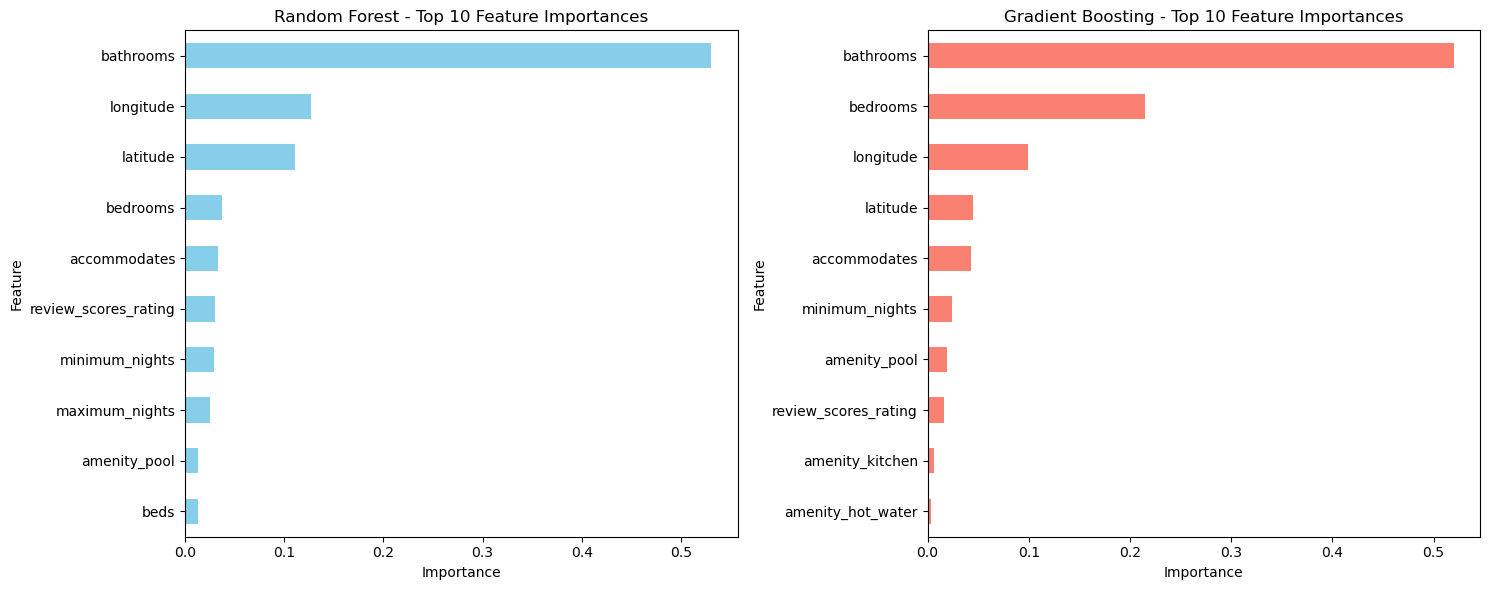

In [296]:
import matplotlib.pyplot as plt

# Extract the top 10 features for each model
rf_top10 = rf_importances.head(10)
gb_top10 = gb_importances.head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot Random Forest top 10 features
rf_top10.sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title("Random Forest - Top 10 Feature Importances")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

# Plot Gradient Boosting top 10 features
gb_top10.sort_values().plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title("Gradient Boosting - Top 10 Feature Importances")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()
